In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy.stats

sns.set_style("white")

In [2]:
# read in the data without the user info at the beginning and end of the file
# https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html
crime_raw = pd.read_csv('NEW_YORK-Offenses_Known_to_Law_Enforcement_by_City_2013-13tbl8ny.csv',
                    header=4,
                    skipfooter = 3,
                    warn_bad_lines = True,
                    skip_blank_lines = True,
                    engine='python',
                   encoding="utf-8")
    # warning said to use engine = python to use the skip blank lines parameter

crime_raw.head()

,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3
0,Adams Village,"1,861",0,0,NaN,0,0,0,12,2,10,0,0.0
1,Addison Town and Village,"2,577",3,0,NaN,0,0,3,24,3,20,1,0.0
2,Akron Village,"2,846",3,0,NaN,0,0,3,16,1,15,0,0.0
3,Albany,"97,956",791,8,NaN,30,227,526,"4,090",705,"3,243",142,NaN
4,Albion Village,"6,388",23,0,NaN,3,4,16,223,53,165,5,NaN


In [6]:
# Tidy the column names
crime_raw.columns = crime_raw.columns.str.strip().str.lower()

replacement_name = {' ':'_', 
                           '(':'',
                           ')':'',
                           '\n':'_',
                           '3':'',
                           '-':''}
for name in replacement_name:
    crime_raw.columns = crime_raw.columns.str.replace(name,replacement_name[name])
    
# Set city as the index (since it's the only categorical data)
crime_raw = crime_raw.set_index('city')
    
# Replace nans with 0s
crime_raw = crime_raw.fillna(value=0)

# Convert all values to floats. Remove commas from larger numbers
for col in crime_raw.columns:
    try:
        crime_raw[col] = crime_raw[col].apply(lambda x: float(x.replace(',', '')))
    except:
        crime_raw[col] = crime_raw[col].apply(lambda x: float(x))

# Rename long name for column header
crime_raw.rename(columns={'murder_and_nonnegligent_manslaughter':'murder_nnm'}, 
          inplace=True)

In [4]:
crime_raw.describe()

,population,violent_crime,murder_and_nonnegligent_manslaughter,rape_revised_definition1,rape_legacy_definition2,robbery,aggravated_assault,property_crime,burglary,larceny_theft,motor_vehicle_theft,arson
count,3.480000e+02,348.000000,348.000000,348.0,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000
mean,4.003763e+04,201.594828,1.566092,0.0,5.864943,72.902299,121.261494,792.606322,119.683908,637.017241,35.905172,1.005747
std,4.500374e+05,2815.268504,18.303673,0.0,60.425452,1031.032873,1706.131730,7659.724746,924.948789,6346.054451,403.423826,7.884612
min,5.260000e+02,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.003000e+03,2.000000,0.000000,0.0,0.000000,0.000000,1.000000,40.500000,6.000000,31.000000,0.000000,0.000000
50%,7.233500e+03,6.000000,0.000000,0.0,0.000000,1.000000,4.000000,112.500000,17.500000,94.000000,2.000000,0.000000
75%,1.842750e+04,22.000000,0.000000,0.0,2.000000,5.000000,14.000000,341.000000,51.250000,287.250000,7.000000,0.000000
max,8.396126e+06,52384.000000,335.000000,0.0,1112.000000,19170.000000,31767.000000,141971.000000,16606.000000,117931.000000,7434.000000,132.000000


In [5]:
# Rape – revised definition 1 is empty. Get rid of it and give rape2 a cleaner name
crime_raw['rape'] = crime_raw['rape_legacy_definition2']
crime_raw = crime_raw.drop(['rape_revised_definition1', 'rape_legacy_definition2'], axis='columns')

### Look at population, murder, and robbery data

/Users/research/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


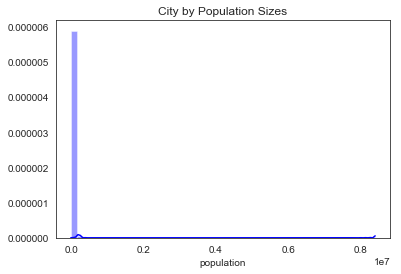

In [7]:
sns.distplot(crime_raw['population'], color="b")
plt.title("City by Population Sizes")
plt.show()

### There is one city over 1,000,000 that's skewing the population data

In [8]:
# Find the outlier
crime_raw[(crime_raw["population"] > 1000000)][
    ["population", "murder_nnm", "robbery"]]

,population,murder_nnm,robbery
city,,,
New York,8396126.0,335.0,19170.0


In [9]:
# NYC greatly skews the data so I'll remove it from the main dataset
nyc = crime_raw.loc['New York']
crime_raw = crime_raw.drop(['New York'], axis='index')

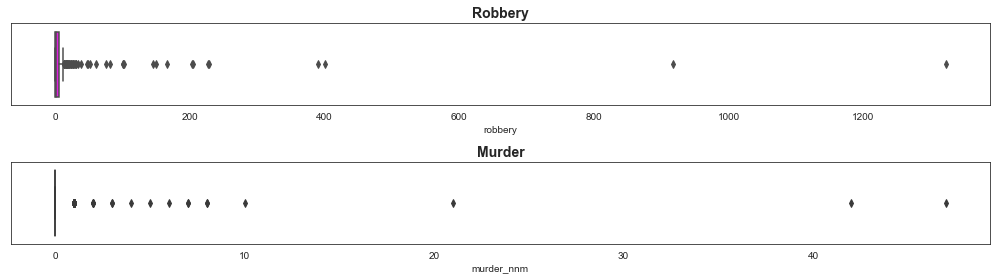

In [10]:
#plot to look for outliers without the NYC data
rob = crime_raw['robbery']
mur = crime_raw['murder_nnm']
fig, axes = plt.subplots(2, 1, sharex=False, figsize=(14,4))
# Robbery plot
sns.boxplot(rob, ax=axes[0], color='fuchsia').set_title('Robbery', fontsize=14, fontweight='bold')    
# Murder plot
sns.boxplot(mur, ax=axes[1], color='m').set_title('Murder', fontsize=14, fontweight='bold')
    
plt.tight_layout()
plt.show()

### There are extreme outliers in robbery and murder

In [11]:
crime_raw[(crime_raw["robbery"] > 250) & (crime_raw["murder_nnm"] > 10)][
    ["population", "murder_nnm", "robbery"]]

,population,murder_nnm,robbery
city,,,
Buffalo,258789.0,47.0,1322.0
Rochester,210562.0,42.0,918.0
Syracuse,143834.0,21.0,400.0


In [12]:
# Windosirze to remove extreme outliers
crime_raw['robbery_wins'] = scipy.stats.mstats.winsorize(crime_raw['robbery'], limits= 0.05)
crime_raw['murder_wins'] = scipy.stats.mstats.winsorize(crime_raw['murder_nnm'], limits= 0.001)

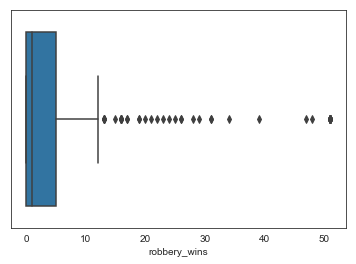

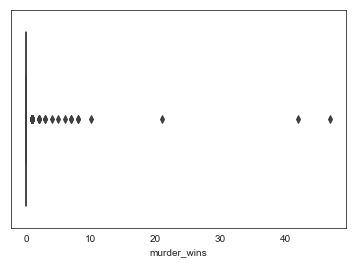

In [13]:
continuous_variables = ['robbery_wins', 'murder_wins']

for var in continuous_variables:
    sns.boxplot(crime_raw[var])
    plt.show()

## Recoding to specification
$ Property crime = \alpha + Population + Population^2 + Murder + Robbery$

In [14]:
features = pd.DataFrame(crime_raw["population"])
features["Pop Squared"] = crime_raw["population"] ** 2
features["Robbery"] = np.where((crime_raw["robbery"] > 0), 1, 0)
features["Murder"] = np.where((crime_raw["murder_nnm"] > 0), 1, 0)

In [15]:
features.head()

,population,Pop Squared,Robbery,Murder
city,,,,
Adams Village,1861.0,3.463321e+06,0,0
Addison Town and Village,2577.0,6.640929e+06,0,0
Akron Village,2846.0,8.099716e+06,0,0
Albany,97956.0,9.595378e+09,1,1
Albion Village,6388.0,4.080654e+07,1,0
